In [1]:
%env SPARK_HOME=/usr/hdp/current/spark2-client
import findspark
findspark.init()
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
print('Spark je pripraven ...')

env: SPARK_HOME=/usr/hdp/current/spark2-client
Spark je pripraven ...


Nejprve zjistime zakladni informace o soboru kde jsou ulozena jednotliva hodnoceni. 

In [2]:
ratings = spark.read.format("csv")\
    .option("sep",";")\
    .option("header", "true")\
    .load("/data/books/BX-Book-Ratings.csv")

ratings.printSchema()

print("Pocet hodnoceni = %i" % ratings.count())

books = spark.read.format("csv")\
    .option("sep",";")\
    .option("header", "true")\
    .load("/data/books/BX-Books.csv")

books.printSchema()

print("Pocet knih = %i" % books.count())

root
 |-- User-ID: string (nullable = true)
 |-- ISBN: string (nullable = true)
 |-- Book-Rating: string (nullable = true)

Pocet hodnoceni = 1149780
root
 |-- ISBN: string (nullable = true)
 |-- Book-Title: string (nullable = true)
 |-- Book-Author: string (nullable = true)
 |-- Year-Of-Publication: string (nullable = true)
 |-- Publisher: string (nullable = true)
 |-- Image-URL-S: string (nullable = true)
 |-- Image-URL-M: string (nullable = true)
 |-- Image-URL-L: string (nullable = true)

Pocet knih = 271379


In [8]:
from pyspark.sql.functions import expr, col, column

ratings = ratings.withColumn('rating', ratings['Book-Rating'].cast('int'))
byRating = ratings.groupBy('rating').count().orderBy(col("rating").asc())
byRating.toPandas().head(11)

,rating,count
0,0,716109
1,1,1770
2,2,2759
3,3,5996
4,4,8904
5,5,50974
6,6,36924
7,7,76457
8,8,103736
9,9,67541


In [29]:
%matplotlib inline

import matplotlib.pyplot as plt

ratings = ratings.withColumn('rating', ratings['Book-Rating'].cast('int'))
byRating = ratings.groupBy('rating').count().orderBy(col("count").desc())
byRating.toPandas().hist(column='rating', range=[0, 10], bins=12)
plt.show()

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:45981)
Traceback (most recent call last):
  File "/usr/hdp/current/spark2-client/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 929, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/hdp/current/spark2-client/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1067, in start
    self.socket.connect((self.address, self.port))
ConnectionRefusedError: [Errno 111] Connection refused


Py4JNetworkError: An error occurred while trying to connect to the Java server (127.0.0.1:45981)

In [6]:
from pyspark.sql.functions import col

userRatingCount = ratings.groupBy("User-ID").count().orderBy(col("count").desc())
print("Pocet hodnoticich uzivatelu = %i" % userRatingCount.count())

Pocet hodnoticich uzivatelu = 105283


In [7]:
ratings.groupBy("ISBN")\
    .count()\
    .join(books, ratings["ISBN"] == books["ISBN"], "left_outer")\
    .select("count", "Book-Title", "Book-Author", "Year-Of-Publication")\
    .orderBy(col("count").desc())\
    .show()

+-----+--------------------+---------------+-------------------+
|count|          Book-Title|    Book-Author|Year-Of-Publication|
+-----+--------------------+---------------+-------------------+
| 2502|         Wild Animus|   Rich Shapero|               2004|
| 1295|The Lovely Bones:...|   Alice Sebold|               2002|
|  883|   The Da Vinci Code|      Dan Brown|               2003|
|  732|Divine Secrets of...|  Rebecca Wells|               1997|
|  723|The Red Tent (Bes...|  Anita Diamant|               1998|
|  647|     A Painted House|   John Grisham|               2001|
|  639|                null|           null|               null|
|  615|The Secret Life o...|  Sue Monk Kidd|               2003|
|  614|Snow Falling on C...| David Guterson|               1995|
|  586| Angels &amp; Demons|      Dan Brown|               2001|
|  585|Where the Heart I...|   Billie Letts|               1998|
|  571|Harry Potter and ...|  J. K. Rowling|               1999|
|  568|The Pilot's Wife .

In [25]:
userRatingCount.show(50)

+-------+-----+
|User-ID|count|
+-------+-----+
|  11676|13602|
| 198711| 7550|
| 153662| 6109|
|  98391| 5891|
|  35859| 5850|
| 212898| 4785|
| 278418| 4533|
|  76352| 3367|
| 110973| 3100|
| 235105| 3067|
| 230522| 2991|
|  16795| 2948|
| 234623| 2674|
|  36836| 2529|
|  52584| 2512|
| 245963| 2507|
| 204864| 2504|
|  55492| 2459|
| 185233| 2448|
| 171118| 2421|
| 102967| 2352|
| 232131| 2347|
| 227447| 2340|
|  98741| 2317|
| 129358| 2317|
|  60244| 2236|
| 190925| 2154|
| 135149| 2100|
| 231210| 2017|
| 189835| 1973|
| 189334| 1924|
|  69697| 1915|
|  78783| 1879|
| 177458| 1819|
| 172742| 1810|
|  73394| 1804|
| 242824| 1747|
| 269566| 1737|
| 213350| 1718|
|  23768| 1708|
| 238781| 1685|
| 175003| 1670|
| 226545| 1623|
|  36606| 1607|
| 182085| 1606|
|  11601| 1571|
| 148744| 1550|
| 123981| 1549|
|  26544| 1535|
|  43246| 1534|
+-------+-----+
only showing top 50 rows



In [10]:
%matplotlib inline

import matplotlib.pyplot as plt

userRatingCountPandas = userRatingCount.where('count>0').toPandas()
print("Pocet hodnoceni = %i" % userRatingCount.count())
print("Pocet hodnoceni = %i" % userRatingCountPandas.size)

Pocet hodnoceni = 105283
Pocet hodnoceni = 210566


In [11]:
print(userRatingCountPandas)

       User-ID  count
0        11676  13602
1       198711   7550
2       153662   6109
3        98391   5891
4        35859   5850
...        ...    ...
105278  144001      1
105279  146276      1
105280  150694      1
105281  153894      1
105282  156162      1

[105283 rows x 2 columns]


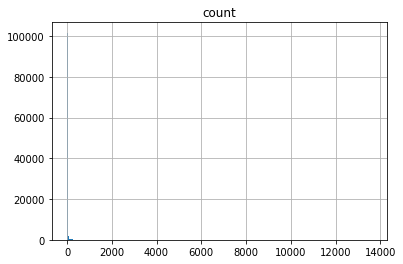

In [12]:
userRatingCountPandas.hist(column='count', bins=300)
plt.show()